## Imports

In [9]:
import nltk
from pathlib import Path
import pandas as pd
import networkx as nx
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

### Figure 3a

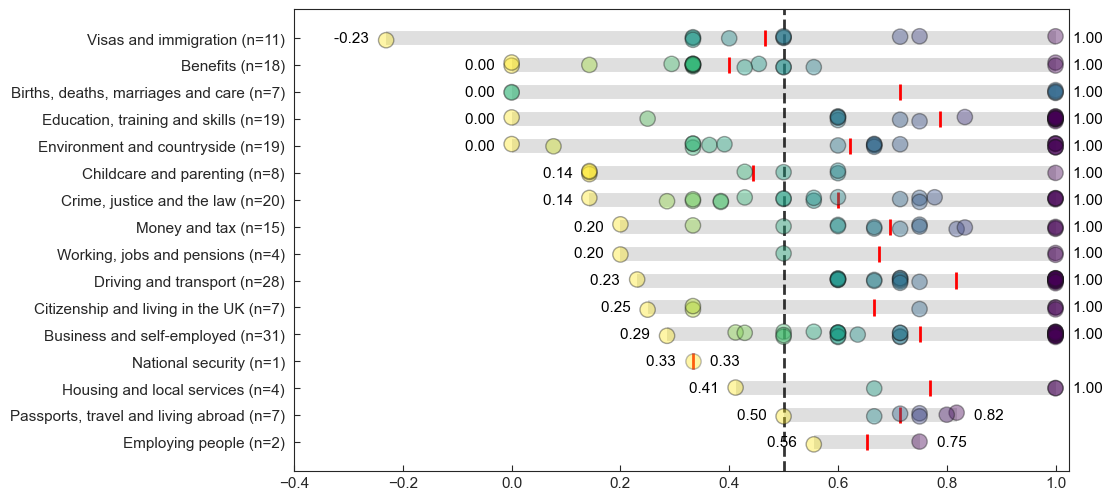

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def plot_dot_plot(save=True):
    # Load dataframe
    analysis_df = pd.read_pickle('../data/processed/dataframes/analysis-df-w-api-data.pkl')

    # Add service count
    for topic in analysis_df.topic.unique():
        service_count = len(analysis_df.loc[analysis_df['topic'] == topic])
        analysis_df.topic.replace(to_replace=topic, value=f'{topic} (n={service_count}) ', inplace=True)

    # Sort y-axis variables in ascending order according to the lowest RTI value
    sorted_topics = analysis_df.groupby('topic')['RTI'].min().sort_values(ascending=True).index

    # Switch the y and x-axis orientation
    plt.figure(figsize=(10, 6))
    sns.set_style('ticks') 
    
    # Add a vertical red line at x=0.75 with alpha 0.8
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.8, linewidth=2)

    # Iterate through unique topics in the sorted order
    for topic in sorted_topics:
        topic_data = analysis_df[analysis_df['topic'] == topic]['RTI']

        # Plot the stripplot
        sns.stripplot(x=topic_data, y=[topic]*len(topic_data), 
                      jitter=True,
                      linewidth=1, alpha=.4,
                      palette='viridis_r', size=11,
                      hue=topic_data)

        # Add numbers for the minimum and maximum values
        min_value = topic_data.min()
        max_value = topic_data.max()
        plt.text(min_value, topic, f'{min_value:.2f}    ', color='black', va='center', ha='right', fontsize=11)
        plt.text(max_value, topic, f'    {max_value:.2f}', color='black', va='center', ha='left', fontsize=11)

        # Add a light grey rectangle spanning the range of data points
        plt.fill_betweenx(y=topic, x1=min_value, x2=max_value, color='gray', alpha=0.25, linewidth=10)   

        # Get the y-axis positions for each topic
        y_axis_positions = plt.gca().get_yticks()

        # Find the position for the current topic
        y_position = y_axis_positions[list(sorted_topics).index(topic)]

        # Calculate the mean for the topic's data
        mean_value = topic_data.mean()

        # Calculate the height of each data point
        data_point_height = 0.6  # You may adjust this value

        # Draw a vertical line at the mean value with the same height as data points
        plt.vlines(x=mean_value, ymin=y_position - data_point_height / 2, ymax=y_position + data_point_height / 2,
                   color='red', linestyle='-', linewidth=2)

    # Use the viridis color palette with reversed order for each topic
    sns.set_palette(sns.color_palette('viridis_r', n_colors=len(analysis_df['topic'].unique())))

    # Add inward-facing major and minor tick marks to all axes
    plt.tick_params(axis='both', which='major', length=4, direction='in')
    plt.tick_params(axis='both', which='minor', length=8, direction='in')

    # Display the plot
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(-0.4, 1.025)
    plt.yticks(fontsize=11)
    plt.xticks(fontsize=11)
    plt.legend([], [], frameon=False)

    # Save figure
    if save:
        plt.savefig(Path("../reports/figures/fig3a.png"), dpi=1200, bbox_inches='tight')
    else:
        plt.show()

plot_dot_plot(save=True)

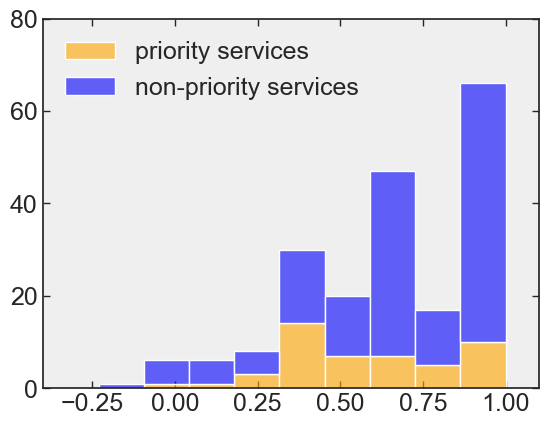

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_histogram_ast(save=False):
    
    # Load dataframe
    analysis_df = pd.read_pickle('../data/processed/dataframes/analysis-df-w-api-data.pkl')

    # Set style and context
    sns.set(style="ticks")
    sns.set_context("notebook", rc={"axes.labelsize": 17, "xtick.labelsize": 17, "ytick.labelsize": 17})

    # Create a histogram with stacked bars and specify colors
    sns.histplot(data=analysis_df, x="RTI", hue='priority', multiple="stack", palette={False: 'blue', True: 'orange'}, alpha=.6)

    # Increase legend font size, remove title, and modify labels
    plt.legend(['priority services', 'non-priority services'], title='', fontsize=18, frameon=False)
    plt.xlabel('', fontsize=14)
    plt.ylabel('', fontsize=14)
    plt.ylim(0,80)
    plt.xlim(-.4,1.1)
    
    # Set the face color
    plt.gca().set_facecolor('#efefef')

    # Add inward-facing major and minor tick marks to all axes
    plt.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True,
        bottom=True,
        left=True,
        labelsize=18,
            width=1,
            length=5
        )

    # Save figure
    if save:
        plt.savefig(Path("../reports/figures/fig3a-inset.png"), dpi=1200, bbox_inches='tight')
    else:
        plt.show()

plot_histogram_ast(save=True)

### Figure 3b

In [299]:
import numpy as np

# Load analysis_df from pickle file
analysis_df = pd.read_pickle('../data/processed/dataframes/analysis-df-w-api-data.pkl')

# Load headcount_df from Excel file
headcount_df = pd.read_excel(
    '../data/processed/2021-2023-ODP-AOA-headcount.xlsx',
    usecols={'organisation': str, 'ODP_AOA_headcount': np.int32}
)

# Strip whitespace from 'organisation' column in headcount_df
headcount_df['organisation'] = headcount_df['organisation'].str.strip()

# Merge dataframes based on the 'organisation' column
merged_df = pd.merge(analysis_df, headcount_df, on='organisation', how='left')

# Create the 'ODP_AOA_headcount' column in analysis_df and fill with values from headcount_df
analysis_df['ODP_AOA_headcount'] = merged_df['ODP_AOA_headcount'].fillna(0)

# Create a new dataframe with columns
result_df = pd.DataFrame(columns=[
    'Share of routine tasks', 
    '# of services', 
    '% of services', 
    '# of services (priority)',
    '% of services (priority)',
    '# of organisations', 
    '# of organisations (priority)', 
    '# of service delivery professionals',
    '# of service delivery professionals (priority)'
])

# Step 3: Fill '# of services'
result_df.loc['RTI=0'] = [0] * 9  # Initialize the row with zeros
result_df.at['RTI=0', '# of services'] = len(
    analysis_df[analysis_df['RTI_perc'] == 0])

result_df.loc['RTI<0.5'] = [0] * 9
result_df.at['RTI<0.5', '# of services'] = len(
    analysis_df[(analysis_df['RTI_perc'] < 50)])

result_df.loc['RTI>=0.5'] = [0] * 9
result_df.at['RTI>=0.5', '# of services'] = len(
    analysis_df[(analysis_df['RTI_perc'] >= 50)])

result_df.loc['RTI>=0.75'] = [0] * 9
result_df.at['RTI>=0.75', '# of services'] = len(
    analysis_df[(analysis_df['RTI_perc'] >= 75)])

result_df.loc['RTI=1'] = [0] * 9
result_df.at['RTI=1', '# of services'] = len(
    analysis_df[analysis_df['RTI_perc'] == 100])

# Step 4: Fill '% of services'
result_df['% of services'] = (result_df['# of services'] / len(analysis_df['service'])) * 100

# Step 5: Fill # of organisations
result_df.at['RTI=0', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] == 0].organisation.unique())
result_df.at['RTI<0.5', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] < 50].organisation.unique())
result_df.at['RTI>=0.5', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] >= 50].organisation.unique())
result_df.at['RTI>=0.75', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] >= 75].organisation.unique())
result_df.at['RTI=1', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] == 100].organisation.unique())

result_df.at['RTI=0', '# of organisations (priority)'] = len(
    analysis_df.loc[(analysis_df['RTI_perc'] == 0) & (analysis_df['priority'] == True)].organisation.unique())
result_df.at['RTI<0.5', '# of organisations (priority)'] = len(
    analysis_df.loc[(analysis_df['RTI_perc'] < 50) & (analysis_df['priority'] == True)].organisation.unique())
result_df.at['RTI>=0.5', '# of organisations (priority)'] = len(
    analysis_df.loc[(analysis_df['RTI_perc'] >= 50) & (analysis_df['priority'] == True)].organisation.unique())
result_df.at['RTI>=0.75', '# of organisations (priority)'] = len(
    analysis_df.loc[(analysis_df['RTI_perc'] >= 75) & (analysis_df['priority'] == True)].organisation.unique())
result_df.at['RTI=1', '# of organisations (priority)'] = len(
    analysis_df.loc[(analysis_df['RTI_perc'] == 100) & (analysis_df['priority'] == True)].organisation.unique())

# Step 3: Fill '# of services'
result_df.at['RTI=0', '# of services'] = len(
    analysis_df[analysis_df['RTI_perc'] == 0])

result_df.at['RTI<0.5', '# of services'] = len(
    analysis_df[(analysis_df['RTI_perc'] < 50)])

result_df.at['RTI>=0.5', '# of services'] = len(
    analysis_df[(analysis_df['RTI_perc'] >= 50)])

result_df.at['RTI>=0.75', '# of services'] = len(
    analysis_df[(analysis_df['RTI_perc'] >= 75)])

result_df.at['RTI=1', '# of services'] = len(
    analysis_df[analysis_df['RTI_perc'] == 100])

# Step 4: Fill '% of services'
result_df['% of services'] = (result_df['# of services'] / len(analysis_df['service'])) * 100

# Step 4: Fill '# of services (priority)'
result_df.at['RTI=0', '# of services (priority)'] = len(
    analysis_df[(analysis_df['RTI_perc'] == 0) & (analysis_df['priority'] == True)])

result_df.at['RTI<0.5', '# of services (priority)'] = len(
    analysis_df[(analysis_df['RTI_perc'] < 50) & (analysis_df['priority'] == True)])

result_df.at['RTI>=0.5', '# of services (priority)'] = len(
    analysis_df[(analysis_df['RTI_perc'] >= 50) & (analysis_df['priority'] == True)])

result_df.at['RTI>=0.75', '# of services (priority)'] = len(
    analysis_df[(analysis_df['RTI_perc'] >= 75) & (analysis_df['priority'] == True)])

result_df.at['RTI=1', '# of services (priority)'] = len(
    analysis_df[(analysis_df['RTI_perc'] == 100) & (analysis_df['priority'] == True)])

# Step 5: Fill '% of services'
result_df['% of services (priority)'] = (result_df['# of services (priority)'] / len(analysis_df.loc[analysis_df['priority'] == True])) * 100

# Step 6: Fill # of organisations
result_df.at['RTI=0', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] == 0].organisation.unique())
result_df.at['RTI<0.5', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] < 50].organisation.unique())
result_df.at['RTI>=0.5', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] >= 50].organisation.unique())
result_df.at['RTI>=0.75', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] >= 75].organisation.unique())
result_df.at['RTI=1', '# of organisations'] = len(
    analysis_df.loc[analysis_df['RTI_perc'] == 100].organisation.unique())

# Step 7: Fill # of employess
headcounts = dict(zip(analysis_df.organisation, analysis_df.ODP_AOA_headcount))

h_t = 0
for org in analysis_df.loc[analysis_df['RTI_perc'] == 0].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI=0', '# of service delivery professionals'] = h_t

h_t = 0
for org in analysis_df.loc[analysis_df['RTI_perc'] < 50].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI<0.5', '# of service delivery professionals'] = h_t

h_t = 0
for org in analysis_df.loc[analysis_df['RTI_perc'] >= 50].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI>=0.5', '# of service delivery professionals'] = h_t

h_t = 0
for org in analysis_df.loc[analysis_df['RTI_perc'] >= 75].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI>=0.75', '# of service delivery professionals'] = h_t

h_t = 0
for org in analysis_df.loc[analysis_df['RTI_perc'] == 100].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI=1', '# of service delivery professionals'] = h_t


headcounts = dict(zip(analysis_df.organisation, analysis_df.ODP_AOA_headcount))

h_t = 0
for org in analysis_df.loc[(analysis_df['RTI_perc'] == 0) & (analysis_df['priority'] == True)].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI=0', '# of service delivery professionals (priority)'] = h_t

h_t = 0
for org in analysis_df.loc[(analysis_df['RTI_perc'] < 50)  & (analysis_df['priority'] == True)].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI<0.5', '# of service delivery professionals (priority)'] = h_t

h_t = 0
for org in analysis_df.loc[(analysis_df['RTI_perc'] >= 50)  & (analysis_df['priority'] == True)].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI>=0.5', '# of service delivery professionals (priority)'] = h_t

h_t = 0
for org in analysis_df.loc[(analysis_df['RTI_perc'] >= 75)  & (analysis_df['priority'] == True)].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI>=0.75', '# of service delivery professionals (priority)'] = h_t

h_t = 0
for org in analysis_df.loc[(analysis_df['RTI_perc'] == 100)  & (analysis_df['priority'] == True)].organisation.unique():
    h_t += headcounts[org]
result_df.at['RTI=1', '# of service delivery professionals (priority)'] = h_t

result_df

,Share of routine tasks,# of services,% of services,# of services (priority),% of services (priority),# of organisations,# of organisations (priority),# of service delivery professionals,# of service delivery professionals (priority)
RTI=0,0,0,0.000000,0,0.000000,0,0,0,0
RTI<0.5,0,1,0.497512,0,0.000000,1,0,10430,0
RTI>=0.5,0,200,99.502488,48,100.000000,46,18,76233,54260
RTI>=0.75,0,149,74.129353,28,58.333333,41,14,75523,53540
RTI=1,0,66,32.835821,10,20.833333,30,7,70133,4230


- All operational delivery professional Administrative Officers and Assistant employees ≈ 111,092

- Operational delivery professionals include: Administrative Officers and Assistants, Executive Officers, Senior and Higher Executive Officers, Grades 6 and 7 and Senior Civil Service Level; above we report only Administrative Officers and Assistants (AOA) headcounts


- Notes: Users should note the variable and high non-response rates for professions and functions for a number of organisations and should exercise appropriate caution when drawing conclusions from these statistics or when making comparisons between organisations or over time. Numbers are rounded to the nearest ten, and cells containing between one and five employees are represented by "..". Cabinet Office (excl. agencies) did not supply professions information on 9,340 of their staff. Source: https://www.gov.uk/government/statistics/summary-of-civil-servants-in-the-operational-delivery-profession-2021

- Source for Cabinet Office, Department for Education, Institute for Apprenticeships and Technical Education Department for Health and Social Care: https://www.gov.uk/government/statistics/civil-service-statistics-2022/statistical-bulletin-civil-service-statistics-2022#profession

- Source for Office for Product Safety and Standards: https://assets.publishing.service.gov.uk/media/5fca117c8fa8f5474d282ac1/opss-delivery-report-2019-2020.pdf

- Source for DWP: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiB6t-FvNWCAxVWXEEAHWjFArgQFnoECBAQAQ&url=https%3A%2F%2Fassets.publishing.service.gov.uk%2Fmedia%2F5c9b32a0e5274a528752d56c%2Fworkforce-management-feb-2019.csv&usg=AOvVaw05VFp73VX7W02ZFvepa3oh&opi=89978449

- Excluded organisationsStud (which all have n < 3 servies except for the Environment Agency where n=13) because data are not available: : ent Loans Company, Innovate UK, NHS Business Services Authority, The Charity Commission, Disclosure and Barring Service, Care Quality Commissions, Office for Zero Emission Vehicles, Marine Management Organisation, NHS Digital, General Register Office, Environment Agency, Department for Digital, Culture, Media and Sport

### Figure 3c

C:\Users\VincentS\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:white'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\VincentS\AppData\Local\Temp\ipykernel_22792\130529162.py:48: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [100]  # Adjust the size of the marker
C:\Users\VincentS\AppData\Local\Temp\ipykernel_22792\130529162.py:50: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_facecolor('#f8c25f')  # Set the face color


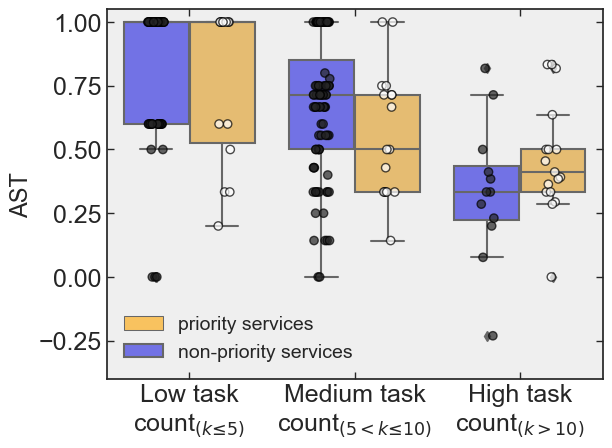

In [147]:
def plot_box_plot_ast(save=True):
    # Load dataframe
    analysis_df = pd.read_pickle('../data/processed/dataframes/analysis-df-w-api-data.pkl')

    # Define the bin edges
    bins = [0, 5, 10, 25]

    # Define the bin labels
    labels = ['\nLow task\ncount$_{(\it{k}≤5)}$', '\nMedium task\ncount$_{(5<\it{k}≤10)}$', '\nHigh task\ncount$_{(\it{k}>10)}$']

    # Create a new column 'task_count_group' with the assigned groups
    analysis_df['task_count_group'] = pd.cut(analysis_df['task_count'], bins=bins, 
                                             labels=labels, 
                                             include_lowest=True)

    # Create a boxplot
    sns.boxplot(data=analysis_df, x='task_count_group', y='RTI', dodge=True, hue='priority', palette={False: '#5f5ff8', True: '#f8c25f'})
    
    # Create a stripplot without legend
    stripplot = sns.stripplot(data=analysis_df, x='task_count_group', y='RTI', dodge=True, alpha=.7, color='white', 
                              edgecolor='black', linewidth=1, size=6, hue='priority', legend=False)
    
    plt.xlabel('')
    plt.ylabel('AST')
    plt.ylim(-.4, 1.05)

    # Set the face color
    plt.gca().set_facecolor('#efefef')

    # Add inward-facing major and minor tick marks to all axes
    plt.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True,
        bottom=True,
        left=True,
        labelsize=18,
        width=1,
        length=5
    )

    # Move the legend above the plot and set ncol to 1
    legend = plt.legend(['priority services', 'non-priority services'], title='', fontsize=14, frameon=False, ncol=1)

    # Set the color of 'priority services' legend item
    legend.legendHandles[0]._sizes = [100]  # Adjust the size of the marker
    legend.legendHandles[0].set_facecolor('#f8c25f')  # Set the face color

    # Save figure
    if save:
        plt.savefig(Path("../reports/figures/fig3c.png"), dpi=1200, bbox_inches='tight')
    else:
        plt.show()

plot_box_plot_ast(save=True)

### Figure 3d

In [70]:
analysis_df = pd.read_pickle('../data/processed/dataframes/analysis-df-w-api-data.pkl')

df = analysis_df.loc[analysis_df['rubric_score_manual'].notnull()][['service', 'task_count', 'RTI', 'rubric_score_manual', 'topic', 'organisation']].sort_values(by='rubric_score_manual')

for i in ['LP', 'MP', 'HP']: 
    print(len(df.loc[df['rubric_score_manual'] == i].organisation.unique()))
    print(df.loc[df['rubric_score_manual'] == i].topic.unique())
    print('\n')

4
['National security' 'Business and self-employed' 'Benefits'
 'Visas and immigration']


7
['Benefits' 'Working, jobs and pensions'
 'Citizenship and living in the UK' 'Business and self-employed'
 'Visas and immigration' 'Crime, justice and the law'
 'Environment and countryside']


1
['Environment and countryside']


